In [ ]:
import os
import pandas as pd

directory_path = '/content'

for file_name in os.listdir(directory_path):
    if file_name.endswith('.csv'):
        full_file_path = os.path.join(directory_path, file_name)

        data = pd.read_csv(full_file_path)

        data_input = data[data['Type'] == 'Input']
        data_output = data[data['Type'] == 'Output']

        base_name = file_name.split('.')[0]

        input_file_path = os.path.join(directory_path, f'{base_name}_Inputs.csv')
        output_file_path = os.path.join(directory_path, f'{base_name}_Outputs.csv')

        data_input.to_csv(input_file_path, index=False)
        data_output.to_csv(output_file_path, index=False)

        print(f'Processed {file_name}:')
        print(f'  Input data saved to: {input_file_path}')
        print(f'  Output data saved to: {output_file_path}')


Processed embeddings(RedditPlatformAgnostic).csv:
  Input data saved to: /content/embeddings(RedditPlatformAgnostic)_Inputs.csv
  Output data saved to: /content/embeddings(RedditPlatformAgnostic)_Outputs.csv


In [ ]:
##%%
import numpy as np
import requests
import pandas as pd
import ast
import re
from scipy.spatial.distance import cosine

api_key = "*******************************************"

def get_embeddings(text):
    """Fetch embeddings for the given text using an external API."""
    headers = {"Authorization": f"Bearer {api_key}"}
    data = {"input": text, "model": "text-embedding-3-large"}
    response = requests.post("https://api.openai.com/v1/embeddings", headers=headers, json=data)
    if response.status_code == 200:
        embedding = response.json()['data'][0]['embedding']
        return np.array(embedding)
    else:
        print(f"Error with text: {text[:30]}... Status code: {response.status_code}")
        return None

def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    return 1 - cosine(vec1, vec2)

def extract_response(text):
    """Extract response texts from a given API call text."""
    responselit = (text.splitlines())[-1].replace('] [','],[')
    responselit = ast.literal_eval(responselit)
    return [responselit[0][0], responselit[1][0], responselit[2][0]]

def extract_examples(text):
    """Extract example texts from a given API call text."""
    example = text.split('###')[1].replace('\n',' ').strip()
    matches = re.findall(r'Example \d+: (.*?)(?=Time:|$)', example, re.DOTALL)
    return [matches[0], matches[1], matches[2]]

file_path = "Log_Reddit_Agnostic.txt"

inputs, outputs = [], []

with open(file_path, "r", encoding='ascii',errors='replace') as file:
    file_contents = file.read()

subtxt = file_contents.split('Using following examples')
subtxt.pop(0)

for apicall in subtxt:
    try:

        if '''['json error']''' not in apicall:
            ini = extract_examples(apicall)
            outi = extract_response(apicall)

            if len(ini) == len(outi):

                inputs.append(ini)
                outputs.append(outi)
            else:
                continue
    except:
        continue


embeddings = []
similarity_matrices = []

for set_index, (input_set, output_set) in enumerate(zip(inputs, outputs), start=1):
    input_embeddings = [get_embeddings(text) for text in input_set]
    output_embeddings = [get_embeddings(text) for text in output_set]

    for i, emb in enumerate(input_embeddings):
        embeddings.append(('Input', set_index, i+1, emb.tolist()))
    for i, emb in enumerate(output_embeddings):
        embeddings.append(('Output', set_index, i+1, emb.tolist()))

    similarity_matrix = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            similarity = cosine_similarity(input_embeddings[i], output_embeddings[j])
            similarity_matrix[i][j] = similarity

    df = pd.DataFrame(similarity_matrix, index=[f'Set{set_index} Input {i+1}' for i in range(3)], columns=[f'Set{set_index} Output {j+1}' for j in range(3)])
    similarity_matrices.append(df)

all_similarity_matrix = pd.concat(similarity_matrices)
all_similarity_matrix.to_excel('all_similarity_matrix.xlsx')
print('All similarity matrices concatenated and saved to all_similarity_matrix.xlsx.')

embeddings_df = pd.DataFrame(embeddings, columns=['Type', 'Set', 'Index', 'Embedding'])
embeddings_df.to_csv('embeddings.csv', index=False)
print('Embedding vectors saved to embeddings.csv.')


All similarity matrices concatenated and saved to all_similarity_matrix.xlsx.
Embedding vectors saved to embeddings.csv.


In [ ]:
import pandas as pd
import numpy as np
import re

file_path = '/content/all_similarity_matrix_Instagram.xlsx'
all_similarity_matrix = pd.read_excel(file_path, index_col=0)

results = []

set_numbers = set(re.findall(r'Set(\d+)', ' '.join(all_similarity_matrix.columns)))

for set_number in sorted(set_numbers, key=int):
    cols_of_set = [col for col in all_similarity_matrix.columns if re.match(f"Set{set_number}\s", col)]

    print(f"Processing Set {set_number}: Columns: {cols_of_set}")

    similarity_matrix = all_similarity_matrix[cols_of_set].dropna()

    if similarity_matrix.shape == (3, 3):
        sorted_values = np.sort(similarity_matrix.values, axis=None)
        highest_values = sorted_values[-3:]
        lowest_values = sorted_values[:3]

        average_of_top_3 = np.mean(highest_values)
        average_of_bottom_3 = np.mean(lowest_values)

        results.append([
            set_number,
            highest_values.tolist(),
            average_of_top_3,
            lowest_values.tolist(),
            average_of_bottom_3
        ])

results_df = pd.DataFrame(results, columns=[
    'Set Index',
    'Top 3 Similarity Scores',
    'Average of Top 3',
    'Bottom 3 Similarity Scores',
    'Average of Bottom 3'
])

results_df.to_csv('/content/bottom_top_3_similarity_scores_(TwitterPlatformAware).csv', index=False)

print('Top and bottom 3 similarity scores and their averages saved to bottom_top_3_similarity_scores.csv.')


Processing Set 1: Columns: ['Set1 Output 1', 'Set1 Output 2', 'Set1 Output 3']
Processing Set 2: Columns: ['Set2 Output 1', 'Set2 Output 2', 'Set2 Output 3']
Processing Set 3: Columns: ['Set3 Output 1', 'Set3 Output 2', 'Set3 Output 3']
Processing Set 4: Columns: ['Set4 Output 1', 'Set4 Output 2', 'Set4 Output 3']
Processing Set 5: Columns: ['Set5 Output 1', 'Set5 Output 2', 'Set5 Output 3']
Processing Set 6: Columns: ['Set6 Output 1', 'Set6 Output 2', 'Set6 Output 3']
Processing Set 7: Columns: ['Set7 Output 1', 'Set7 Output 2', 'Set7 Output 3']
Processing Set 8: Columns: ['Set8 Output 1', 'Set8 Output 2', 'Set8 Output 3']
Processing Set 9: Columns: ['Set9 Output 1', 'Set9 Output 2', 'Set9 Output 3']
Processing Set 10: Columns: ['Set10 Output 1', 'Set10 Output 2', 'Set10 Output 3']
Processing Set 11: Columns: ['Set11 Output 1', 'Set11 Output 2', 'Set11 Output 3']
Processing Set 12: Columns: ['Set12 Output 1', 'Set12 Output 2', 'Set12 Output 3']
Processing Set 13: Columns: ['Set13 Outp

In [ ]:
import os
import pandas as pd

directory = '/content/Insta'

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)

        df = pd.read_csv(file_path)

        if 'Simple Text' in df.columns:
            df = df.drop('Simple Text', axis=1)

        df['Set_Index'] = (df.index // 3) + 1

        new_file_path = os.path.join(directory, f"modified_{filename}")
        df.to_csv(new_file_path, index=False)

        print(f"Processed and saved: {new_file_path}")

print("All files processed.")


Processed and saved: /content/Insta/modified_TikTok_Platform_Aware.csv
Processed and saved: /content/Insta/modified_Instagram_Platform_Agnostic.csv
Processed and saved: /content/Insta/modified_Twitter_Real.csv
Processed and saved: /content/Insta/modified_Reddit_Real.csv
Processed and saved: /content/Insta/modified_Reddit_Platform_Aware.csv
Processed and saved: /content/Insta/modified_Instagram_Real.csv
Processed and saved: /content/Insta/modified_Facebook_Real.csv
Processed and saved: /content/Insta/modified_Instagram_Platform_Aware.csv
Processed and saved: /content/Insta/modified_Facebook_Platform_Aware.csv
Processed and saved: /content/Insta/modified_YouTube_Platform_Aware.csv
Processed and saved: /content/Insta/modified_Facebook_Platform_Agnostic.csv
Processed and saved: /content/Insta/modified_Twitter_Platform_Agnostic.csv
Processed and saved: /content/Insta/modified_Twitter_Platform_Aware.csv
Processed and saved: /content/Insta/modified_Reddit_Platform_Agnostic.csv
All files proce

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import ast

def string_to_list(embedding_str):
    try:
        if pd.isna(embedding_str):
            return np.zeros(3072)
        else:
            return ast.literal_eval(embedding_str)
    except ValueError:
        return np.zeros(3072)

file1 = pd.read_csv('/content/Modified/modified_Twitter_Platform_Aware.csv')
file2 = pd.read_csv('/content/Modified/modified_Twitter_Real.csv')

file1['Embedding'] = file1['Embedding'].apply(string_to_list)
file2['Embedding'] = file2['Embedding'].apply(string_to_list)

input_embeddings = np.array(file1['Embedding'].tolist())
output_embeddings = np.array(file2['Embedding'].tolist())

similarity_matrix = cosine_similarity(input_embeddings, output_embeddings)

df_similarity = pd.DataFrame(similarity_matrix,
                             index=[f'File1 Embedding {i+1}' for i in range(len(input_embeddings))],
                             columns=[f'File2 Embedding {j+1}' for j in range(len(output_embeddings))])

df_similarity.to_excel('full_similarity_matrix_Twitter_Aware.xlsx')
print('Full similarity matrix saved to full_similarity_matrix.xlsx.')


Full similarity matrix saved to full_similarity_matrix.xlsx.


In [ ]:
import pandas as pd
import numpy as np

similarity_matrix_df = pd.read_excel('full_similarity_matrix_YouTube_Aware.xlsx', index_col=0)

all_values = similarity_matrix_df.values.flatten()

sorted_values = np.sort(all_values)

num_elements = 1000

if len(sorted_values) >= num_elements:
    top_avg = sorted_values[-num_elements:].mean()

    overall_average = np.mean(all_values)
    print(f"Average of top {num_elements} values: {top_avg}")
    print(f"Overall average of similarity scores: {overall_average}")
else:
    print("Not enough values in the matrix to calculate the specified top and bottom averages.")


Average of top 1000 values: 0.8758880257244008
Overall average of similarity scores: 0.29150255061242264


In [ ]:
##t-SNE

Skipping 1 rows with invalid embeddings in Instagram Platform_Aware


<ipython-input-7-0d8886a0fb98>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Platform'] = platform
<ipython-input-7-0d8886a0fb98>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Scenario'] = scenario


Skipping 1 rows with invalid embeddings in Instagram Platform_Agnostic


<ipython-input-7-0d8886a0fb98>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Platform'] = platform
<ipython-input-7-0d8886a0fb98>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Scenario'] = scenario


Skipping 1 rows with invalid embeddings in TikTok Real


<ipython-input-7-0d8886a0fb98>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Platform'] = platform
<ipython-input-7-0d8886a0fb98>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Scenario'] = scenario


Skipping 1 rows with invalid embeddings in YouTube Real


<ipython-input-7-0d8886a0fb98>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Platform'] = platform
<ipython-input-7-0d8886a0fb98>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Scenario'] = scenario
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.p

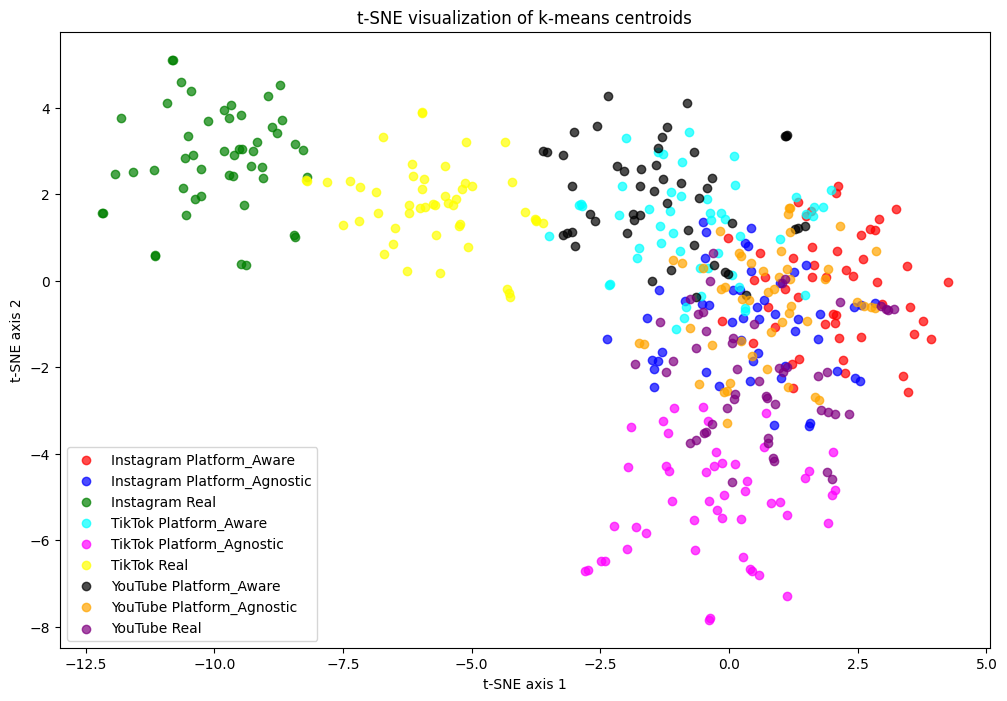

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def convert_embedding(string_embedding):
    if pd.isna(string_embedding):
        return None
    try:
        return np.array(eval(string_embedding))
    except (SyntaxError, TypeError):
        return None
frames = []
for platform in ['Instagram', 'TikTok', 'YouTube']:
    for scenario in ['Platform_Aware', 'Platform_Agnostic', 'Real']:
        path = f'/content/{platform}_{scenario}.csv'
        df = pd.read_csv(path)
        df['Embedding'] = df['Embedding'].apply(convert_embedding)

        skipped_rows = df[df['Embedding'].isnull()]
        if not skipped_rows.empty:
            print(f"Skipping {len(skipped_rows)} rows with invalid embeddings in {platform} {scenario}")

        df = df.dropna(subset=['Embedding'])
        df['Platform'] = platform
        df['Scenario'] = scenario
        frames.append(df)

combined_data = pd.concat(frames, ignore_index=True)

platforms = ['Instagram', 'TikTok', 'YouTube']
scenarios = ['Platform_Aware', 'Platform_Agnostic', 'Real']
color_map = {
    ('Instagram', 'Platform_Aware'): 'red',
    ('Instagram', 'Platform_Agnostic'): 'blue',
    ('Instagram', 'Real'): 'green',
    ('TikTok', 'Platform_Aware'): 'cyan',
    ('TikTok', 'Platform_Agnostic'): 'magenta',
    ('TikTok', 'Real'): 'yellow',
    ('YouTube', 'Platform_Aware'): 'black',
    ('YouTube', 'Platform_Agnostic'): 'orange',
    ('YouTube', 'Real'): 'purple'
}
tsne_results = []
labels = []

for platform in platforms:
    for scenario in scenarios:
        subset = combined_data[(combined_data['Platform'] == platform) & (combined_data['Scenario'] == scenario)]
        embeddings = np.array(subset['Embedding'].tolist())

        kmeans = KMeans(n_clusters=50, random_state=42)
        kmeans.fit(embeddings)
        cluster_centers = kmeans.cluster_centers_

        tsne = TSNE(n_components=2, random_state=42)
        tsne_cluster_results = tsne.fit_transform(cluster_centers)
        tsne_results.extend(tsne_cluster_results)
        labels.extend([(platform, scenario)] * len(cluster_centers))

# Plotting
plt.figure(figsize=(12, 8))
for label, (x, y) in zip(labels, tsne_results):
    plt.scatter(x, y, color=color_map[label], label=f'{label[0]} {label[1]}', alpha=0.7)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('t-SNE visualization of k-means centroids')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.show()
